# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

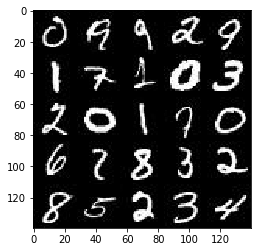

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# print(mnist_images[0])
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

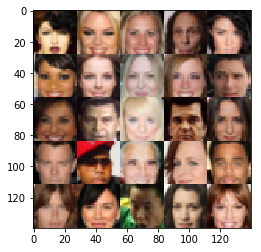

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='z_dim')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28*28*?
        #print(images.shape)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        #print(x1.shape)
        x1 = tf.maximum(alpha * x1, x1)
        # 14*14*64
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        #print(x2.shape)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7*7*256
        
#         x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
#         #print(x3.shape)
#         x3 = tf.layers.batch_normalization(x3, training=True)
#         x3 = tf.maximum(alpha * x3, x3)
#         # 4*4*256

        # Flatten it
        flat = tf.reshape(x2, (-1, 7*7*256))
        #print(flat.shape)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        #print(x1.shape)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # now 7*7*256
        
#         x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='valid')
#         #print(x2.shape)
#         x2 = tf.layers.batch_normalization(x2, training=is_train)
#         x2 = tf.maximum(alpha * x2, x2)
#         # 7*7*128 now
        
        x3 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        #print(x3.shape)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14*14*64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.shape)
        # 28*28*? now
        
#         out = tf.tanh(logits) * 0.5
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_count, image_width, image_height, image_channels = data_shape
    input_real, input_z, tf_lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, tf_lr, beta1)
    
    print_every = 20
    show_every = 200
    steps = 0
    total_batches = int(image_count/batch_size)+1
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                #print(batch_images.shape) # => (128, 28, 28, 1)
                steps += 1
                batch_i += 1
                # TODO: Train Model
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images, tf_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, tf_lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("E {:}/{} B {:>4}/{}...".format(epoch_i+1, epoch_count, batch_i, total_batches),
                          "D: {:.4f}...".format(train_loss_d),
                          "G: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
        # final show
        show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

In [16]:
# mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
# print(mnist_dataset.shape) # => (60000, 28, 28, 1)
# print(mnist_dataset.image_mode) # => L

E 1/2 B   20/469... D: 0.6182... G: 3.5452
E 1/2 B   40/469... D: 1.0150... G: 1.7407
E 1/2 B   60/469... D: 1.5759... G: 0.4375
E 1/2 B   80/469... D: 1.1026... G: 1.8260
E 1/2 B  100/469... D: 1.6025... G: 0.3420
E 1/2 B  120/469... D: 1.6705... G: 2.0543
E 1/2 B  140/469... D: 1.0940... G: 0.9886
E 1/2 B  160/469... D: 1.2068... G: 0.7589
E 1/2 B  180/469... D: 1.6049... G: 0.3751
E 1/2 B  200/469... D: 1.9542... G: 0.2307


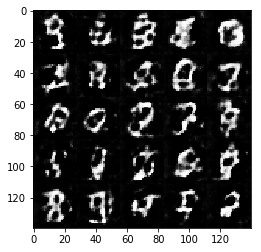

E 1/2 B  220/469... D: 1.0810... G: 2.2318
E 1/2 B  240/469... D: 1.1459... G: 1.8318
E 1/2 B  260/469... D: 1.1646... G: 2.5575
E 1/2 B  280/469... D: 1.2514... G: 2.4286
E 1/2 B  300/469... D: 0.9156... G: 1.3742
E 1/2 B  320/469... D: 1.1210... G: 0.6558
E 1/2 B  340/469... D: 2.2407... G: 0.1640
E 1/2 B  360/469... D: 1.0554... G: 1.2545
E 1/2 B  380/469... D: 1.0816... G: 1.7645
E 1/2 B  400/469... D: 1.1011... G: 1.0837


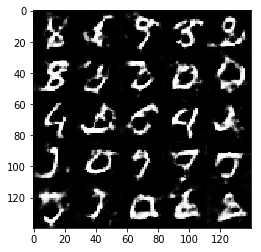

E 1/2 B  420/469... D: 1.1242... G: 1.5451
E 1/2 B  440/469... D: 1.4294... G: 0.4692
E 1/2 B  460/469... D: 1.3332... G: 0.5296
E 2/2 B   12/469... D: 1.0487... G: 1.6768
E 2/2 B   32/469... D: 1.1265... G: 0.7252
E 2/2 B   52/469... D: 1.1310... G: 0.9856
E 2/2 B   72/469... D: 1.7505... G: 0.2766
E 2/2 B   92/469... D: 1.1188... G: 1.3678
E 2/2 B  112/469... D: 1.1304... G: 0.6072
E 2/2 B  132/469... D: 1.2935... G: 0.5692


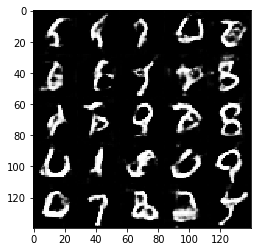

E 2/2 B  152/469... D: 1.1684... G: 0.6647
E 2/2 B  172/469... D: 1.0915... G: 0.7903
E 2/2 B  192/469... D: 1.4059... G: 0.4472
E 2/2 B  212/469... D: 1.1433... G: 0.5918
E 2/2 B  232/469... D: 1.7861... G: 2.6410
E 2/2 B  252/469... D: 1.0387... G: 0.7399
E 2/2 B  272/469... D: 0.9019... G: 1.4361
E 2/2 B  292/469... D: 1.1643... G: 1.4973
E 2/2 B  312/469... D: 1.3936... G: 2.3011
E 2/2 B  332/469... D: 1.0924... G: 0.6985


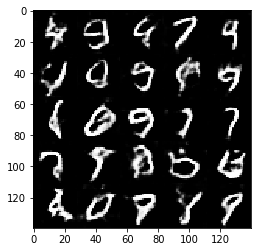

E 2/2 B  352/469... D: 1.5151... G: 0.3774
E 2/2 B  372/469... D: 1.0838... G: 0.7934
E 2/2 B  392/469... D: 1.1548... G: 0.5696
E 2/2 B  412/469... D: 1.3397... G: 2.4707
E 2/2 B  432/469... D: 1.0155... G: 1.5706
E 2/2 B  452/469... D: 1.4760... G: 0.4139


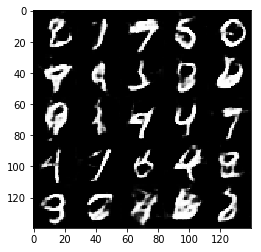

In [29]:
batch_size = 128
z_dim = 90
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

In [212]:
# celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
# print(celeba_dataset.shape) # => (202599, 28, 28, 3)
# print(celeba_dataset.image_mode) # => RGB

E 1/5 B   20/3166... D: 0.1390... G: 10.9572
E 1/5 B   40/3166... D: 0.6000... G: 18.2997
E 1/5 B   60/3166... D: 0.8978... G: 2.0403
E 1/5 B   80/3166... D: 1.3103... G: 0.7418
E 1/5 B  100/3166... D: 1.7730... G: 2.9914
E 1/5 B  120/3166... D: 1.4254... G: 0.7672
E 1/5 B  140/3166... D: 1.0780... G: 0.8514
E 1/5 B  160/3166... D: 1.6126... G: 0.2989
E 1/5 B  180/3166... D: 0.7843... G: 1.1491
E 1/5 B  200/3166... D: 1.0769... G: 0.8317


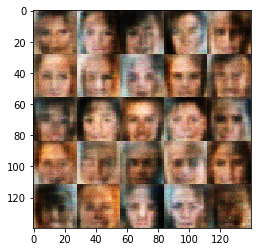

E 1/5 B  220/3166... D: 1.9047... G: 0.2560
E 1/5 B  240/3166... D: 1.4229... G: 0.7173
E 1/5 B  260/3166... D: 1.1790... G: 6.3186
E 1/5 B  280/3166... D: 0.2451... G: 3.2973
E 1/5 B  300/3166... D: 0.9757... G: 0.8072
E 1/5 B  320/3166... D: 0.1383... G: 5.5301
E 1/5 B  340/3166... D: 0.1257... G: 7.3175
E 1/5 B  360/3166... D: 0.0788... G: 4.4390
E 1/5 B  380/3166... D: 3.1735... G: 0.0623
E 1/5 B  400/3166... D: 0.1502... G: 6.0017


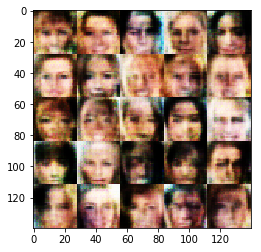

E 1/5 B  420/3166... D: 0.3738... G: 2.5395
E 1/5 B  440/3166... D: 0.2796... G: 6.6600
E 1/5 B  460/3166... D: 0.1166... G: 5.9710
E 1/5 B  480/3166... D: 0.8026... G: 0.9745
E 1/5 B  500/3166... D: 0.2144... G: 3.6240
E 1/5 B  520/3166... D: 0.2335... G: 7.0470
E 1/5 B  540/3166... D: 0.3821... G: 6.4105
E 1/5 B  560/3166... D: 0.3218... G: 2.7078
E 1/5 B  580/3166... D: 1.7916... G: 2.2906
E 1/5 B  600/3166... D: 0.6163... G: 1.4325


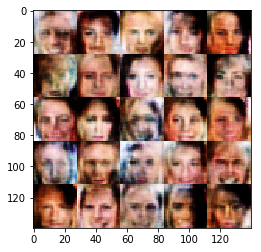

E 1/5 B  620/3166... D: 0.3738... G: 2.0789
E 1/5 B  640/3166... D: 1.5753... G: 0.3500
E 1/5 B  660/3166... D: 0.3575... G: 2.2428
E 1/5 B  680/3166... D: 0.9062... G: 1.1854
E 1/5 B  700/3166... D: 0.5017... G: 1.7280
E 1/5 B  720/3166... D: 0.2951... G: 2.8473
E 1/5 B  740/3166... D: 1.0005... G: 1.4321
E 1/5 B  760/3166... D: 0.6938... G: 3.8908
E 1/5 B  780/3166... D: 0.3374... G: 2.6567
E 1/5 B  800/3166... D: 0.9345... G: 0.9558


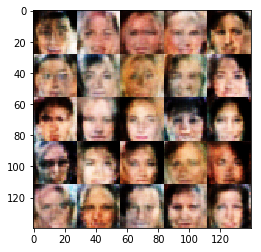

E 1/5 B  820/3166... D: 0.3247... G: 3.2082
E 1/5 B  840/3166... D: 0.2758... G: 2.7932
E 1/5 B  860/3166... D: 0.3904... G: 2.1670
E 1/5 B  880/3166... D: 2.8004... G: 2.0627
E 1/5 B  900/3166... D: 0.3440... G: 2.6963
E 1/5 B  920/3166... D: 0.5780... G: 1.5813
E 1/5 B  940/3166... D: 1.3010... G: 1.1201
E 1/5 B  960/3166... D: 1.6690... G: 0.3256
E 1/5 B  980/3166... D: 0.8138... G: 1.1672
E 1/5 B 1000/3166... D: 0.7316... G: 1.1127


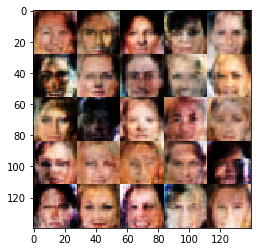

E 1/5 B 1020/3166... D: 0.4992... G: 1.7916
E 1/5 B 1040/3166... D: 1.0909... G: 0.8835
E 1/5 B 1060/3166... D: 0.7728... G: 1.5308
E 1/5 B 1080/3166... D: 0.5015... G: 3.3607
E 1/5 B 1100/3166... D: 0.5206... G: 3.7865
E 1/5 B 1120/3166... D: 0.5002... G: 3.0558
E 1/5 B 1140/3166... D: 1.1926... G: 1.0555
E 1/5 B 1160/3166... D: 0.4363... G: 2.2058
E 1/5 B 1180/3166... D: 1.1872... G: 0.9618
E 1/5 B 1200/3166... D: 0.7517... G: 3.5573


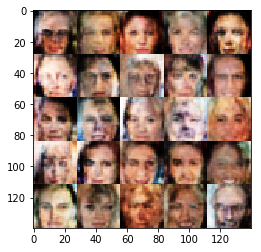

E 1/5 B 1220/3166... D: 0.8620... G: 1.3864
E 1/5 B 1240/3166... D: 1.1185... G: 0.8359
E 1/5 B 1260/3166... D: 0.7035... G: 1.5662
E 1/5 B 1280/3166... D: 0.3365... G: 3.4037
E 1/5 B 1300/3166... D: 2.8984... G: 1.2348
E 1/5 B 1320/3166... D: 1.6347... G: 1.5928
E 1/5 B 1340/3166... D: 0.6604... G: 2.2022
E 1/5 B 1360/3166... D: 0.7614... G: 1.1027
E 1/5 B 1380/3166... D: 1.1189... G: 1.5525
E 1/5 B 1400/3166... D: 0.6264... G: 2.4771


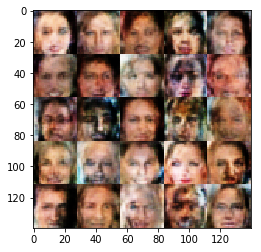

E 1/5 B 1420/3166... D: 0.5135... G: 1.9150
E 1/5 B 1440/3166... D: 2.2695... G: 0.1445
E 1/5 B 1460/3166... D: 0.9188... G: 1.1297
E 1/5 B 1480/3166... D: 0.7003... G: 1.1728
E 1/5 B 1500/3166... D: 1.0251... G: 0.7165
E 1/5 B 1520/3166... D: 0.8315... G: 1.0266
E 1/5 B 1540/3166... D: 0.7058... G: 1.0982
E 1/5 B 1560/3166... D: 1.1182... G: 4.5708
E 1/5 B 1580/3166... D: 0.6815... G: 1.8737
E 1/5 B 1600/3166... D: 1.4897... G: 0.4034


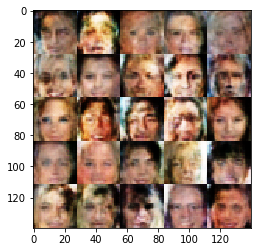

E 1/5 B 1620/3166... D: 0.9979... G: 0.7951
E 1/5 B 1640/3166... D: 0.8517... G: 0.8390
E 1/5 B 1660/3166... D: 0.6052... G: 1.8038
E 1/5 B 1680/3166... D: 1.1166... G: 0.8962
E 1/5 B 1700/3166... D: 1.0096... G: 0.7587
E 1/5 B 1720/3166... D: 0.9712... G: 0.9483
E 1/5 B 1740/3166... D: 0.9995... G: 2.3020
E 1/5 B 1760/3166... D: 1.0943... G: 1.5691
E 1/5 B 1780/3166... D: 0.4738... G: 2.9716
E 1/5 B 1800/3166... D: 1.1201... G: 0.7077


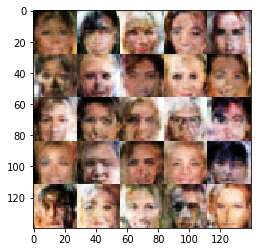

E 1/5 B 1820/3166... D: 0.7086... G: 2.8327
E 1/5 B 1840/3166... D: 0.8261... G: 1.2255
E 1/5 B 1860/3166... D: 0.7090... G: 1.7903
E 1/5 B 1880/3166... D: 0.9113... G: 1.5869
E 1/5 B 1900/3166... D: 2.6843... G: 1.9699
E 1/5 B 1920/3166... D: 1.7929... G: 0.4737
E 1/5 B 1940/3166... D: 1.1477... G: 0.5850
E 1/5 B 1960/3166... D: 0.9179... G: 1.0861
E 1/5 B 1980/3166... D: 1.1039... G: 0.7398
E 1/5 B 2000/3166... D: 0.9414... G: 0.8971


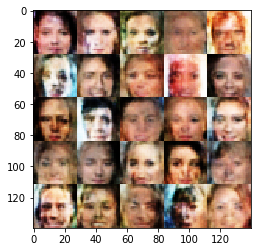

E 1/5 B 2020/3166... D: 0.6631... G: 1.5978
E 1/5 B 2040/3166... D: 0.9385... G: 1.0003
E 1/5 B 2060/3166... D: 1.1382... G: 0.7222
E 1/5 B 2080/3166... D: 0.7889... G: 1.2882
E 1/5 B 2100/3166... D: 0.9396... G: 1.1407
E 1/5 B 2120/3166... D: 0.9740... G: 0.8296
E 1/5 B 2140/3166... D: 1.0947... G: 1.5024
E 1/5 B 2160/3166... D: 1.3671... G: 0.4972
E 1/5 B 2180/3166... D: 0.9827... G: 1.1006
E 1/5 B 2200/3166... D: 0.8635... G: 1.4221


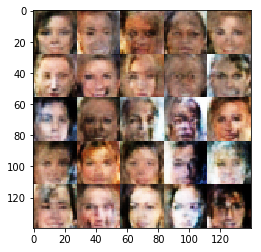

E 1/5 B 2220/3166... D: 1.3974... G: 0.4300
E 1/5 B 2240/3166... D: 0.6128... G: 1.6579
E 1/5 B 2260/3166... D: 1.0061... G: 0.9140
E 1/5 B 2280/3166... D: 2.1785... G: 0.2915
E 1/5 B 2300/3166... D: 1.5637... G: 0.3774
E 1/5 B 2320/3166... D: 0.8271... G: 1.1525
E 1/5 B 2340/3166... D: 0.6781... G: 1.5879
E 1/5 B 2360/3166... D: 1.2591... G: 0.8982
E 1/5 B 2380/3166... D: 1.2280... G: 0.6122
E 1/5 B 2400/3166... D: 1.0520... G: 0.7019


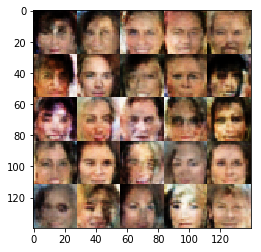

E 1/5 B 2420/3166... D: 0.7407... G: 1.5544
E 1/5 B 2440/3166... D: 0.8478... G: 1.2707
E 1/5 B 2460/3166... D: 1.0247... G: 0.7506
E 1/5 B 2480/3166... D: 0.8453... G: 1.2377
E 1/5 B 2500/3166... D: 1.1679... G: 0.8641
E 1/5 B 2520/3166... D: 0.8421... G: 1.5647
E 1/5 B 2540/3166... D: 0.6593... G: 2.3896
E 1/5 B 2560/3166... D: 1.2577... G: 1.0011
E 1/5 B 2580/3166... D: 0.8945... G: 1.6539
E 1/5 B 2600/3166... D: 1.0059... G: 2.0810


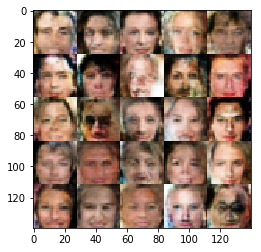

E 1/5 B 2620/3166... D: 0.8708... G: 1.1393
E 1/5 B 2640/3166... D: 0.9076... G: 1.1472
E 1/5 B 2660/3166... D: 0.6680... G: 1.6323
E 1/5 B 2680/3166... D: 1.9911... G: 0.2090
E 1/5 B 2700/3166... D: 2.0248... G: 0.2139
E 1/5 B 2720/3166... D: 0.7255... G: 1.3013
E 1/5 B 2740/3166... D: 0.9309... G: 1.5400
E 1/5 B 2760/3166... D: 2.0223... G: 0.2283
E 1/5 B 2780/3166... D: 1.6904... G: 0.2609
E 1/5 B 2800/3166... D: 0.9492... G: 0.7730


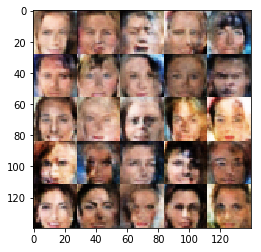

E 1/5 B 2820/3166... D: 1.2728... G: 1.4142
E 1/5 B 2840/3166... D: 0.6705... G: 1.4602
E 1/5 B 2860/3166... D: 2.4849... G: 3.7155
E 1/5 B 2880/3166... D: 1.1631... G: 0.5760
E 1/5 B 2900/3166... D: 1.3667... G: 0.4674
E 1/5 B 2920/3166... D: 1.0475... G: 0.7303
E 1/5 B 2940/3166... D: 0.8499... G: 1.1534
E 1/5 B 2960/3166... D: 0.9078... G: 1.2054
E 1/5 B 2980/3166... D: 2.6237... G: 0.1555
E 1/5 B 3000/3166... D: 1.1870... G: 0.9991


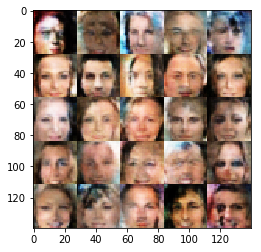

E 1/5 B 3020/3166... D: 1.1992... G: 0.6048
E 1/5 B 3040/3166... D: 0.8713... G: 0.8569
E 1/5 B 3060/3166... D: 1.0470... G: 0.6513
E 1/5 B 3080/3166... D: 0.7007... G: 1.5726
E 1/5 B 3100/3166... D: 1.1378... G: 0.8953
E 1/5 B 3120/3166... D: 0.8788... G: 0.9202
E 1/5 B 3140/3166... D: 2.2643... G: 0.1889
E 1/5 B 3160/3166... D: 1.2374... G: 0.6599
E 2/5 B   15/3166... D: 0.9468... G: 1.0212
E 2/5 B   35/3166... D: 0.8124... G: 1.5189


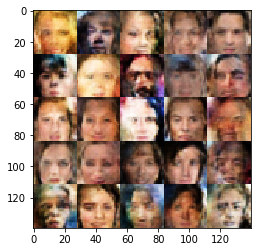

E 2/5 B   55/3166... D: 0.8676... G: 0.8714
E 2/5 B   75/3166... D: 1.2983... G: 0.5401
E 2/5 B   95/3166... D: 0.9279... G: 1.6674
E 2/5 B  115/3166... D: 0.6153... G: 1.5728
E 2/5 B  135/3166... D: 1.7455... G: 0.2682
E 2/5 B  155/3166... D: 1.2425... G: 0.9949
E 2/5 B  175/3166... D: 1.2881... G: 0.4593
E 2/5 B  195/3166... D: 0.8007... G: 1.2618
E 2/5 B  215/3166... D: 1.6000... G: 0.3108
E 2/5 B  235/3166... D: 1.1740... G: 0.7970


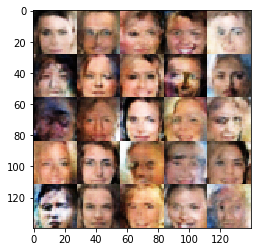

E 2/5 B  255/3166... D: 0.9067... G: 0.8496
E 2/5 B  275/3166... D: 0.8600... G: 1.2842
E 2/5 B  295/3166... D: 0.9666... G: 0.9144
E 2/5 B  315/3166... D: 0.9473... G: 0.7959
E 2/5 B  335/3166... D: 0.7341... G: 1.4756
E 2/5 B  355/3166... D: 2.4196... G: 0.1796
E 2/5 B  375/3166... D: 1.2966... G: 0.5142
E 2/5 B  395/3166... D: 0.7887... G: 1.0199
E 2/5 B  415/3166... D: 0.8579... G: 1.3300
E 2/5 B  435/3166... D: 0.7641... G: 1.0907


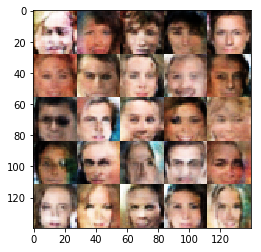

E 2/5 B  455/3166... D: 1.0351... G: 2.4862
E 2/5 B  475/3166... D: 1.0222... G: 0.6410
E 2/5 B  495/3166... D: 0.9957... G: 0.9861
E 2/5 B  515/3166... D: 1.0909... G: 0.7100
E 2/5 B  535/3166... D: 0.8249... G: 1.0940
E 2/5 B  555/3166... D: 0.7693... G: 1.3375
E 2/5 B  575/3166... D: 0.6993... G: 1.1783
E 2/5 B  595/3166... D: 0.7125... G: 1.1766
E 2/5 B  615/3166... D: 1.3262... G: 2.0631
E 2/5 B  635/3166... D: 0.9962... G: 1.0979


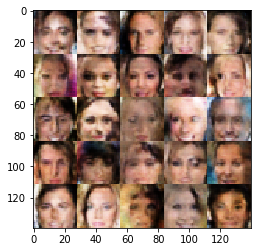

E 2/5 B  655/3166... D: 0.9674... G: 0.7467
E 2/5 B  675/3166... D: 0.7670... G: 1.7574
E 2/5 B  695/3166... D: 1.3510... G: 0.4016
E 2/5 B  715/3166... D: 0.7289... G: 1.5977
E 2/5 B  735/3166... D: 1.1302... G: 0.7550
E 2/5 B  755/3166... D: 0.7911... G: 1.1347
E 2/5 B  775/3166... D: 1.1533... G: 0.6299
E 2/5 B  795/3166... D: 0.7855... G: 1.8607
E 2/5 B  815/3166... D: 0.7674... G: 1.2250
E 2/5 B  835/3166... D: 0.8453... G: 0.8863


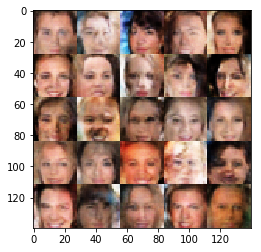

E 2/5 B  855/3166... D: 0.8474... G: 0.9811
E 2/5 B  875/3166... D: 0.9851... G: 0.8051
E 2/5 B  895/3166... D: 3.4045... G: 0.0635
E 2/5 B  915/3166... D: 1.6489... G: 1.3226
E 2/5 B  935/3166... D: 1.4789... G: 0.3699
E 2/5 B  955/3166... D: 0.7249... G: 1.2916
E 2/5 B  975/3166... D: 0.9176... G: 2.1015
E 2/5 B  995/3166... D: 0.9263... G: 0.8350
E 2/5 B 1015/3166... D: 1.1023... G: 0.5814
E 2/5 B 1035/3166... D: 0.6759... G: 1.2316


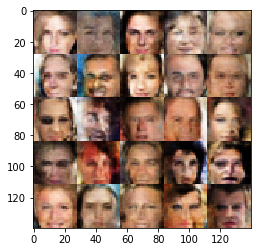

E 2/5 B 1055/3166... D: 3.2583... G: 3.0990
E 2/5 B 1075/3166... D: 1.3101... G: 0.5403
E 2/5 B 1095/3166... D: 1.1644... G: 1.1701
E 2/5 B 1115/3166... D: 0.9843... G: 0.7663
E 2/5 B 1135/3166... D: 1.0239... G: 1.9561
E 2/5 B 1155/3166... D: 0.7969... G: 0.9477
E 2/5 B 1175/3166... D: 0.7082... G: 1.2634
E 2/5 B 1195/3166... D: 1.0591... G: 0.6071
E 2/5 B 1215/3166... D: 1.7514... G: 1.5102
E 2/5 B 1235/3166... D: 1.0145... G: 0.7103


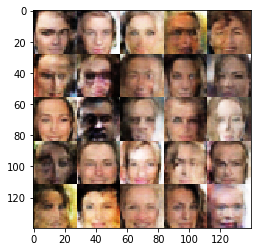

E 2/5 B 1255/3166... D: 1.1666... G: 0.5742
E 2/5 B 1275/3166... D: 0.9178... G: 1.5423
E 2/5 B 1295/3166... D: 0.6647... G: 1.2901
E 2/5 B 1315/3166... D: 0.7838... G: 1.0636
E 2/5 B 1335/3166... D: 0.7470... G: 1.6061
E 2/5 B 1355/3166... D: 0.6522... G: 1.3821
E 2/5 B 1375/3166... D: 1.0061... G: 0.6656
E 2/5 B 1395/3166... D: 0.7982... G: 0.9699
E 2/5 B 1415/3166... D: 0.7986... G: 0.9776
E 2/5 B 1435/3166... D: 1.3377... G: 0.7459


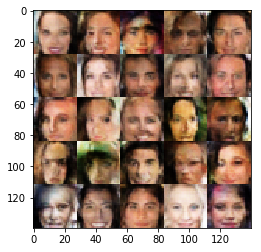

E 2/5 B 1455/3166... D: 1.1605... G: 0.6552
E 2/5 B 1475/3166... D: 1.0519... G: 0.7344
E 2/5 B 1495/3166... D: 1.1903... G: 0.5421
E 2/5 B 1515/3166... D: 0.9499... G: 0.9273
E 2/5 B 1535/3166... D: 1.3786... G: 0.4936
E 2/5 B 1555/3166... D: 0.9859... G: 0.6951
E 2/5 B 1575/3166... D: 1.1558... G: 2.8409
E 2/5 B 1595/3166... D: 1.5673... G: 0.3237
E 2/5 B 1615/3166... D: 0.7990... G: 1.1193
E 2/5 B 1635/3166... D: 0.5578... G: 1.6471


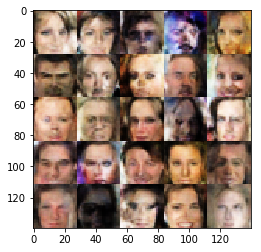

E 2/5 B 1655/3166... D: 0.9496... G: 0.7971
E 2/5 B 1675/3166... D: 0.9622... G: 1.9519
E 2/5 B 1695/3166... D: 1.5006... G: 1.6679
E 2/5 B 1715/3166... D: 1.5066... G: 2.3137
E 2/5 B 1735/3166... D: 0.6726... G: 1.3060
E 2/5 B 1755/3166... D: 0.7125... G: 1.8133
E 2/5 B 1775/3166... D: 0.7953... G: 1.2095
E 2/5 B 1795/3166... D: 0.6967... G: 1.0776
E 2/5 B 1815/3166... D: 1.0151... G: 0.6625
E 2/5 B 1835/3166... D: 1.4999... G: 0.3886


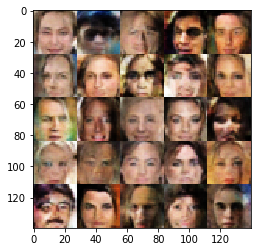

E 2/5 B 1855/3166... D: 0.9948... G: 0.6989
E 2/5 B 1875/3166... D: 1.8836... G: 0.3612
E 2/5 B 1895/3166... D: 0.8471... G: 1.9611
E 2/5 B 1915/3166... D: 0.7630... G: 1.0617
E 2/5 B 1935/3166... D: 0.9328... G: 0.8474
E 2/5 B 1955/3166... D: 0.8992... G: 1.9441
E 2/5 B 1975/3166... D: 0.5174... G: 1.7062
E 2/5 B 1995/3166... D: 0.8967... G: 0.9173
E 2/5 B 2015/3166... D: 0.9333... G: 1.2061
E 2/5 B 2035/3166... D: 1.3676... G: 1.2058


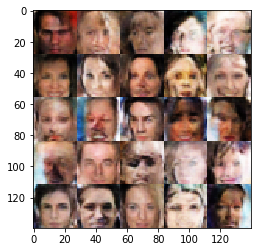

E 2/5 B 2055/3166... D: 0.8910... G: 1.0887
E 2/5 B 2075/3166... D: 1.6268... G: 0.3365
E 2/5 B 2095/3166... D: 1.5649... G: 0.3506
E 2/5 B 2115/3166... D: 1.1766... G: 0.6235
E 2/5 B 2135/3166... D: 1.4027... G: 0.4044
E 2/5 B 2155/3166... D: 1.0968... G: 0.7301
E 2/5 B 2175/3166... D: 0.9559... G: 1.1193
E 2/5 B 2195/3166... D: 0.7873... G: 1.0573
E 2/5 B 2215/3166... D: 1.2851... G: 0.4401
E 2/5 B 2235/3166... D: 0.6402... G: 1.3166


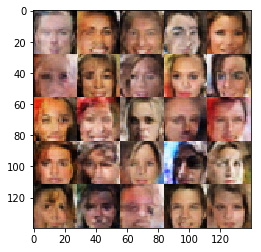

E 2/5 B 2255/3166... D: 0.9781... G: 0.8050
E 2/5 B 2275/3166... D: 0.8031... G: 1.0941
E 2/5 B 2295/3166... D: 0.6994... G: 0.9643
E 2/5 B 2315/3166... D: 1.5506... G: 0.3251
E 2/5 B 2335/3166... D: 1.6207... G: 0.3133
E 2/5 B 2355/3166... D: 0.9000... G: 0.9507
E 2/5 B 2375/3166... D: 0.8185... G: 0.8604
E 2/5 B 2395/3166... D: 0.8054... G: 1.9576
E 2/5 B 2415/3166... D: 0.9411... G: 0.8407
E 2/5 B 2435/3166... D: 1.0541... G: 0.6389


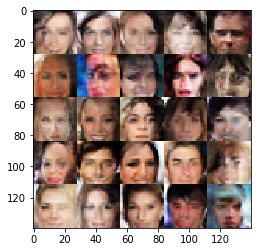

E 2/5 B 2455/3166... D: 0.5802... G: 1.5574
E 2/5 B 2475/3166... D: 0.7332... G: 1.0654
E 2/5 B 2495/3166... D: 0.7319... G: 2.7586
E 2/5 B 2515/3166... D: 0.6569... G: 1.3051
E 2/5 B 2535/3166... D: 1.1296... G: 0.9786
E 2/5 B 2555/3166... D: 1.2572... G: 0.5084
E 2/5 B 2575/3166... D: 0.7460... G: 1.1304
E 2/5 B 2595/3166... D: 0.8649... G: 1.2615
E 2/5 B 2615/3166... D: 0.5386... G: 1.3937
E 2/5 B 2635/3166... D: 0.7270... G: 1.3720


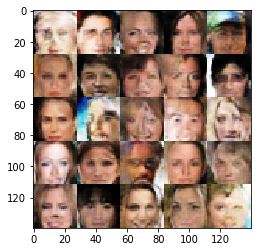

E 2/5 B 2655/3166... D: 1.0614... G: 0.7476
E 2/5 B 2675/3166... D: 0.5811... G: 1.5936
E 2/5 B 2695/3166... D: 1.2403... G: 0.6329
E 2/5 B 2715/3166... D: 0.3565... G: 2.1545
E 2/5 B 2735/3166... D: 0.6005... G: 1.1793
E 2/5 B 2755/3166... D: 7.9000... G: 8.2624
E 2/5 B 2775/3166... D: 2.4921... G: 0.1714
E 2/5 B 2795/3166... D: 2.2218... G: 2.0001
E 2/5 B 2815/3166... D: 1.8097... G: 0.2925
E 2/5 B 2835/3166... D: 1.1597... G: 1.1638


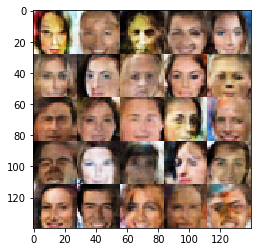

E 2/5 B 2855/3166... D: 0.9136... G: 1.0117
E 2/5 B 2875/3166... D: 0.8758... G: 1.5375
E 2/5 B 2895/3166... D: 1.0067... G: 0.6878
E 2/5 B 2915/3166... D: 0.9459... G: 0.7400
E 2/5 B 2935/3166... D: 0.8912... G: 0.9008
E 2/5 B 2955/3166... D: 1.0291... G: 0.7011
E 2/5 B 2975/3166... D: 1.4098... G: 0.4170
E 2/5 B 2995/3166... D: 0.8013... G: 0.9810
E 2/5 B 3015/3166... D: 1.6069... G: 2.1465
E 2/5 B 3035/3166... D: 0.8334... G: 1.2005


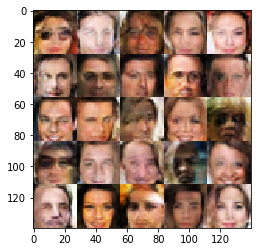

E 2/5 B 3055/3166... D: 0.6117... G: 1.2777
E 2/5 B 3075/3166... D: 1.0976... G: 0.5771
E 2/5 B 3095/3166... D: 0.7120... G: 1.2417
E 2/5 B 3115/3166... D: 0.9163... G: 0.8592
E 2/5 B 3135/3166... D: 0.8033... G: 1.0295
E 2/5 B 3155/3166... D: 1.3772... G: 0.4018
E 3/5 B   10/3166... D: 1.4789... G: 0.4236
E 3/5 B   30/3166... D: 0.9847... G: 0.7737
E 3/5 B   50/3166... D: 1.0099... G: 0.6580
E 3/5 B   70/3166... D: 1.2833... G: 0.5523


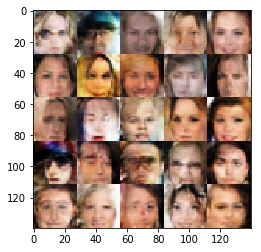

E 3/5 B   90/3166... D: 0.8041... G: 1.9540
E 3/5 B  110/3166... D: 2.4841... G: 0.2133
E 3/5 B  130/3166... D: 0.8565... G: 0.9164
E 3/5 B  150/3166... D: 1.0971... G: 0.6307
E 3/5 B  170/3166... D: 1.0230... G: 0.7676
E 3/5 B  190/3166... D: 1.0623... G: 0.5618
E 3/5 B  210/3166... D: 1.2689... G: 0.6168
E 3/5 B  230/3166... D: 0.8864... G: 0.8571
E 3/5 B  250/3166... D: 1.1179... G: 0.6003
E 3/5 B  270/3166... D: 0.8821... G: 0.8894


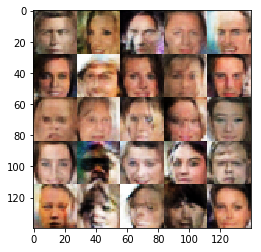

E 3/5 B  290/3166... D: 1.5856... G: 0.3776
E 3/5 B  310/3166... D: 0.6854... G: 1.2380
E 3/5 B  330/3166... D: 1.1123... G: 0.6101
E 3/5 B  350/3166... D: 0.6518... G: 1.4284
E 3/5 B  370/3166... D: 2.1801... G: 0.2445
E 3/5 B  390/3166... D: 0.9328... G: 1.2389
E 3/5 B  410/3166... D: 0.8103... G: 1.1046
E 3/5 B  430/3166... D: 0.8812... G: 0.8679
E 3/5 B  450/3166... D: 0.9276... G: 0.8353
E 3/5 B  470/3166... D: 0.7229... G: 1.2205


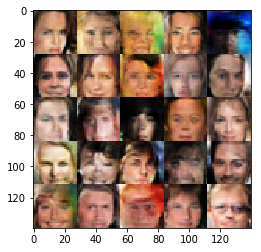

E 3/5 B  490/3166... D: 0.7031... G: 1.0485
E 3/5 B  510/3166... D: 0.9539... G: 0.7812
E 3/5 B  530/3166... D: 0.6977... G: 2.8526
E 3/5 B  550/3166... D: 1.3972... G: 0.4423
E 3/5 B  570/3166... D: 0.9203... G: 0.8363
E 3/5 B  590/3166... D: 0.8506... G: 0.8992
E 3/5 B  610/3166... D: 0.5840... G: 1.2433
E 3/5 B  630/3166... D: 3.1184... G: 5.5403
E 3/5 B  650/3166... D: 1.2691... G: 0.4926
E 3/5 B  670/3166... D: 1.0696... G: 0.6570


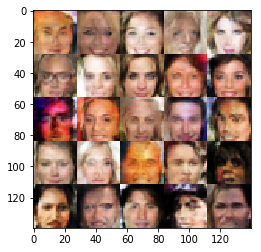

E 3/5 B  690/3166... D: 0.7211... G: 1.1636
E 3/5 B  710/3166... D: 1.0493... G: 0.6212
E 3/5 B  730/3166... D: 2.6334... G: 2.8392
E 3/5 B  750/3166... D: 0.7838... G: 1.2783
E 3/5 B  770/3166... D: 0.8215... G: 0.9191
E 3/5 B  790/3166... D: 0.6710... G: 1.9318
E 3/5 B  810/3166... D: 0.8056... G: 0.9785
E 3/5 B  830/3166... D: 0.9303... G: 0.7795
E 3/5 B  850/3166... D: 0.6196... G: 1.4232
E 3/5 B  870/3166... D: 1.4850... G: 0.3630


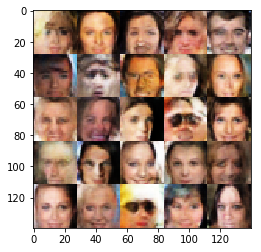

E 3/5 B  890/3166... D: 0.7966... G: 1.0970
E 3/5 B  910/3166... D: 0.5728... G: 1.2073
E 3/5 B  930/3166... D: 0.6126... G: 1.5865
E 3/5 B  950/3166... D: 1.3382... G: 0.4598
E 3/5 B  970/3166... D: 0.6830... G: 1.2209
E 3/5 B  990/3166... D: 1.0436... G: 0.9063
E 3/5 B 1010/3166... D: 1.3361... G: 0.4721
E 3/5 B 1030/3166... D: 1.3892... G: 0.4675
E 3/5 B 1050/3166... D: 0.5789... G: 1.6449
E 3/5 B 1070/3166... D: 0.6098... G: 1.1312


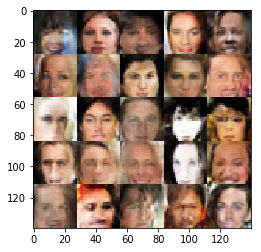

E 3/5 B 1090/3166... D: 0.7357... G: 0.9975
E 3/5 B 1110/3166... D: 3.6142... G: 0.1705
E 3/5 B 1130/3166... D: 1.0662... G: 1.0943
E 3/5 B 1150/3166... D: 0.9729... G: 0.7436
E 3/5 B 1170/3166... D: 0.7943... G: 1.7518
E 3/5 B 1190/3166... D: 1.3326... G: 0.4415
E 3/5 B 1210/3166... D: 1.2767... G: 0.5399
E 3/5 B 1230/3166... D: 1.7311... G: 0.3230
E 3/5 B 1250/3166... D: 0.7752... G: 2.8187
E 3/5 B 1270/3166... D: 0.6444... G: 1.7127


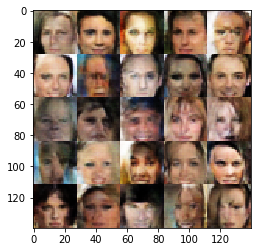

E 3/5 B 1290/3166... D: 1.5779... G: 0.3540
E 3/5 B 1310/3166... D: 0.7642... G: 1.2158
E 3/5 B 1330/3166... D: 0.7074... G: 1.6333
E 3/5 B 1350/3166... D: 0.5616... G: 1.3128
E 3/5 B 1370/3166... D: 0.6785... G: 1.6276
E 3/5 B 1390/3166... D: 0.7685... G: 1.0662
E 3/5 B 1410/3166... D: 0.5785... G: 1.7012
E 3/5 B 1430/3166... D: 0.9901... G: 0.7272
E 3/5 B 1450/3166... D: 0.4897... G: 1.7676
E 3/5 B 1470/3166... D: 0.8005... G: 1.7155


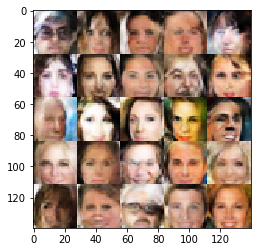

E 3/5 B 1490/3166... D: 0.4735... G: 2.0438
E 3/5 B 1510/3166... D: 0.6577... G: 1.2937
E 3/5 B 1530/3166... D: 0.8025... G: 1.4918
E 3/5 B 1550/3166... D: 1.0587... G: 0.6617
E 3/5 B 1570/3166... D: 0.4097... G: 1.7330
E 3/5 B 1590/3166... D: 0.9269... G: 0.7731
E 3/5 B 1610/3166... D: 1.3526... G: 0.5032
E 3/5 B 1630/3166... D: 1.4953... G: 2.6372
E 3/5 B 1650/3166... D: 1.0500... G: 0.7648
E 3/5 B 1670/3166... D: 0.6910... G: 1.0858


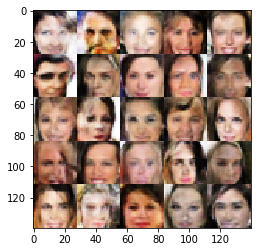

E 3/5 B 1690/3166... D: 0.5562... G: 2.2679
E 3/5 B 1710/3166... D: 0.8047... G: 2.8247
E 3/5 B 1730/3166... D: 0.8463... G: 0.9864
E 3/5 B 1750/3166... D: 0.8469... G: 0.9896
E 3/5 B 1770/3166... D: 1.9518... G: 0.2018
E 3/5 B 1790/3166... D: 0.9958... G: 0.8010
E 3/5 B 1810/3166... D: 0.7860... G: 1.1388
E 3/5 B 1830/3166... D: 0.7196... G: 1.4697
E 3/5 B 1850/3166... D: 0.8347... G: 0.8781
E 3/5 B 1870/3166... D: 0.4775... G: 3.1316


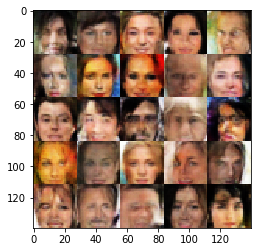

E 3/5 B 1890/3166... D: 0.7342... G: 0.9811
E 3/5 B 1910/3166... D: 3.7273... G: 5.9340
E 3/5 B 1930/3166... D: 0.7497... G: 1.2090
E 3/5 B 1950/3166... D: 0.5811... G: 1.3947
E 3/5 B 1970/3166... D: 0.5042... G: 1.6789
E 3/5 B 1990/3166... D: 0.7969... G: 0.8682
E 3/5 B 2010/3166... D: 0.5421... G: 1.6695
E 3/5 B 2030/3166... D: 0.7956... G: 1.1380
E 3/5 B 2050/3166... D: 0.4985... G: 2.0335
E 3/5 B 2070/3166... D: 1.7141... G: 0.2886


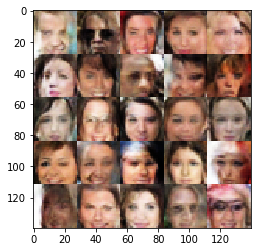

E 3/5 B 2090/3166... D: 1.0128... G: 1.9250
E 3/5 B 2110/3166... D: 1.2587... G: 0.5389
E 3/5 B 2130/3166... D: 0.6528... G: 1.4413
E 3/5 B 2150/3166... D: 1.1670... G: 0.5513
E 3/5 B 2170/3166... D: 1.5838... G: 0.4237
E 3/5 B 2190/3166... D: 1.0664... G: 0.7187
E 3/5 B 2210/3166... D: 1.0717... G: 0.6656
E 3/5 B 2230/3166... D: 1.0296... G: 3.8474
E 3/5 B 2250/3166... D: 0.7572... G: 0.8616
E 3/5 B 2270/3166... D: 1.4479... G: 0.4212


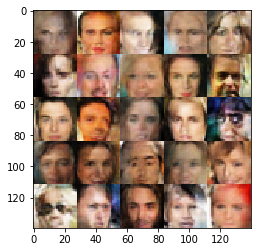

E 3/5 B 2290/3166... D: 0.7007... G: 1.1083
E 3/5 B 2310/3166... D: 0.7055... G: 1.1125
E 3/5 B 2330/3166... D: 0.5802... G: 1.3665
E 3/5 B 2350/3166... D: 0.9480... G: 0.9222
E 3/5 B 2370/3166... D: 1.6562... G: 0.3406
E 3/5 B 2390/3166... D: 1.4837... G: 0.3691
E 3/5 B 2410/3166... D: 0.9487... G: 0.6823
E 3/5 B 2430/3166... D: 0.5986... G: 1.5826
E 3/5 B 2450/3166... D: 0.6178... G: 1.4036
E 3/5 B 2470/3166... D: 0.8068... G: 1.6534


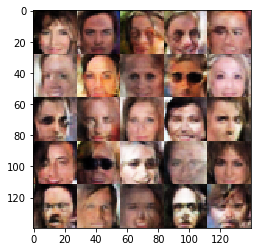

E 3/5 B 2490/3166... D: 0.8784... G: 0.8563
E 3/5 B 2510/3166... D: 2.4846... G: 3.5589
E 3/5 B 2530/3166... D: 2.0772... G: 0.2340
E 3/5 B 2550/3166... D: 0.8838... G: 0.9001
E 3/5 B 2570/3166... D: 1.0520... G: 0.6917
E 3/5 B 2590/3166... D: 0.9521... G: 0.7214
E 3/5 B 2610/3166... D: 1.1271... G: 0.5989
E 3/5 B 2630/3166... D: 0.6518... G: 1.4248
E 3/5 B 2650/3166... D: 1.4141... G: 0.4546
E 3/5 B 2670/3166... D: 0.5208... G: 3.3129


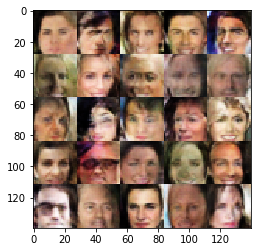

E 3/5 B 2690/3166... D: 1.3812... G: 0.5100
E 3/5 B 2710/3166... D: 0.4860... G: 1.5429
E 3/5 B 2730/3166... D: 0.6289... G: 1.2981
E 3/5 B 2750/3166... D: 1.3164... G: 0.5131
E 3/5 B 2770/3166... D: 0.7058... G: 1.2874
E 3/5 B 2790/3166... D: 0.4892... G: 2.1248
E 3/5 B 2810/3166... D: 0.6868... G: 1.0433
E 3/5 B 2830/3166... D: 1.0123... G: 0.9572
E 3/5 B 2850/3166... D: 0.4841... G: 1.9629
E 3/5 B 2870/3166... D: 0.5759... G: 1.2326


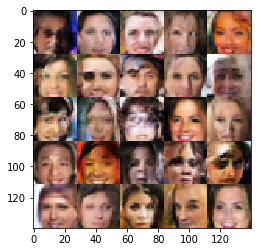

E 3/5 B 2890/3166... D: 0.6716... G: 1.0600
E 3/5 B 2910/3166... D: 0.7668... G: 2.5388
E 3/5 B 2930/3166... D: 0.7594... G: 1.0948
E 3/5 B 2950/3166... D: 0.5259... G: 1.4349
E 3/5 B 2970/3166... D: 0.6560... G: 2.1031
E 3/5 B 2990/3166... D: 0.7319... G: 1.1632
E 3/5 B 3010/3166... D: 0.4659... G: 1.6547
E 3/5 B 3030/3166... D: 6.8493... G: 0.0065
E 3/5 B 3050/3166... D: 1.2927... G: 2.0497
E 3/5 B 3070/3166... D: 0.8864... G: 0.9797


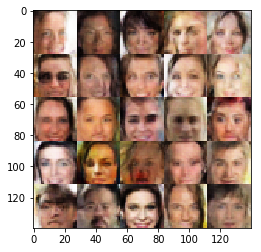

E 3/5 B 3090/3166... D: 1.1462... G: 0.6690
E 3/5 B 3110/3166... D: 0.5656... G: 1.6490
E 3/5 B 3130/3166... D: 0.6670... G: 1.4291
E 3/5 B 3150/3166... D: 0.5820... G: 1.5114
E 4/5 B    5/3166... D: 1.4726... G: 0.4269
E 4/5 B   25/3166... D: 0.9788... G: 0.7320
E 4/5 B   45/3166... D: 0.7082... G: 1.1188
E 4/5 B   65/3166... D: 0.7390... G: 1.5265
E 4/5 B   85/3166... D: 1.0506... G: 0.5992
E 4/5 B  105/3166... D: 3.6698... G: 5.3607


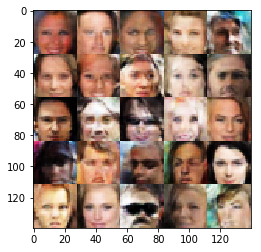

E 4/5 B  125/3166... D: 1.3851... G: 0.4599
E 4/5 B  145/3166... D: 0.7807... G: 1.4763
E 4/5 B  165/3166... D: 0.7184... G: 1.0179
E 4/5 B  185/3166... D: 0.7187... G: 0.9875
E 4/5 B  205/3166... D: 0.7791... G: 1.0809
E 4/5 B  225/3166... D: 4.0344... G: 0.0546
E 4/5 B  245/3166... D: 0.8819... G: 1.1758
E 4/5 B  265/3166... D: 1.0164... G: 0.7567
E 4/5 B  285/3166... D: 0.6552... G: 1.2466
E 4/5 B  305/3166... D: 0.6540... G: 1.2013


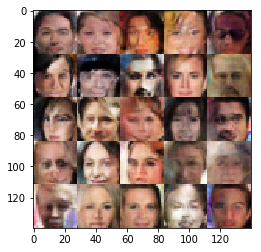

E 4/5 B  325/3166... D: 1.5265... G: 0.3993
E 4/5 B  345/3166... D: 0.5678... G: 1.2984
E 4/5 B  365/3166... D: 1.3441... G: 0.4222
E 4/5 B  385/3166... D: 0.5623... G: 1.4467
E 4/5 B  405/3166... D: 0.6814... G: 2.0862
E 4/5 B  425/3166... D: 0.6531... G: 1.0698
E 4/5 B  445/3166... D: 1.1551... G: 0.5656
E 4/5 B  465/3166... D: 0.5361... G: 1.6001
E 4/5 B  485/3166... D: 0.7914... G: 1.9673
E 4/5 B  505/3166... D: 1.4636... G: 0.4592


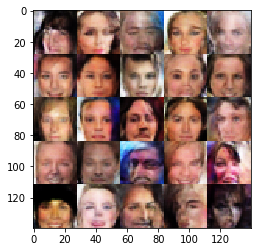

E 4/5 B  525/3166... D: 1.5116... G: 2.4010
E 4/5 B  545/3166... D: 0.8974... G: 0.9296
E 4/5 B  565/3166... D: 0.9012... G: 0.7938
E 4/5 B  585/3166... D: 0.7292... G: 1.0759
E 4/5 B  605/3166... D: 0.6122... G: 1.3639
E 4/5 B  625/3166... D: 2.0845... G: 0.2452
E 4/5 B  645/3166... D: 0.6795... G: 1.6325
E 4/5 B  665/3166... D: 0.7790... G: 1.2079
E 4/5 B  685/3166... D: 0.5790... G: 1.3271
E 4/5 B  705/3166... D: 0.4808... G: 2.7003


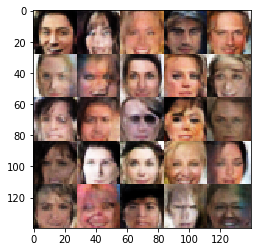

E 4/5 B  725/3166... D: 1.6135... G: 3.3879
E 4/5 B  745/3166... D: 3.1746... G: 0.1455
E 4/5 B  765/3166... D: 0.7898... G: 0.8929
E 4/5 B  785/3166... D: 0.6440... G: 1.1780
E 4/5 B  805/3166... D: 0.7714... G: 1.0551
E 4/5 B  825/3166... D: 1.4614... G: 0.4099
E 4/5 B  845/3166... D: 0.8994... G: 0.8190
E 4/5 B  865/3166... D: 0.8616... G: 2.8614
E 4/5 B  885/3166... D: 1.0026... G: 0.7712
E 4/5 B  905/3166... D: 1.0975... G: 0.6812


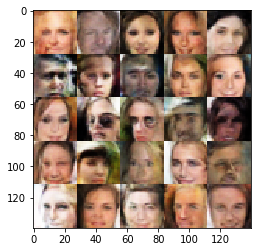

E 4/5 B  925/3166... D: 0.5943... G: 1.2013
E 4/5 B  945/3166... D: 0.9053... G: 0.7816
E 4/5 B  965/3166... D: 0.7251... G: 1.1300
E 4/5 B  985/3166... D: 1.0066... G: 0.7969
E 4/5 B 1005/3166... D: 0.4820... G: 1.7663
E 4/5 B 1025/3166... D: 0.8101... G: 0.8893
E 4/5 B 1045/3166... D: 0.3497... G: 2.2769
E 4/5 B 1065/3166... D: 0.5632... G: 1.4408
E 4/5 B 1085/3166... D: 0.8384... G: 0.8491
E 4/5 B 1105/3166... D: 4.3089... G: 5.7552


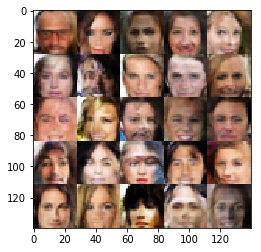

E 4/5 B 1125/3166... D: 1.0414... G: 0.8465
E 4/5 B 1145/3166... D: 0.7137... G: 2.4758
E 4/5 B 1165/3166... D: 1.0388... G: 0.7751
E 4/5 B 1185/3166... D: 0.7589... G: 0.9508
E 4/5 B 1205/3166... D: 2.5219... G: 4.0992
E 4/5 B 1225/3166... D: 1.5115... G: 2.4094
E 4/5 B 1245/3166... D: 1.0426... G: 0.7191
E 4/5 B 1265/3166... D: 0.5856... G: 1.3610
E 4/5 B 1285/3166... D: 0.5770... G: 2.7917
E 4/5 B 1305/3166... D: 0.6343... G: 1.3434


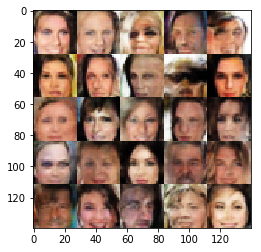

E 4/5 B 1325/3166... D: 0.4570... G: 2.0125
E 4/5 B 1345/3166... D: 1.1200... G: 0.6112
E 4/5 B 1365/3166... D: 0.6532... G: 2.3352
E 4/5 B 1385/3166... D: 1.0336... G: 0.8973
E 4/5 B 1405/3166... D: 1.3815... G: 0.4917
E 4/5 B 1425/3166... D: 1.0778... G: 0.6942
E 4/5 B 1445/3166... D: 1.0331... G: 0.6825
E 4/5 B 1465/3166... D: 0.4199... G: 1.9992
E 4/5 B 1485/3166... D: 0.4650... G: 1.7161
E 4/5 B 1505/3166... D: 1.0620... G: 0.6527


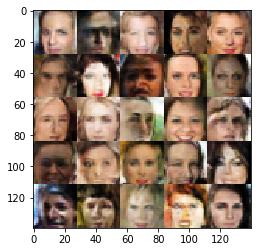

E 4/5 B 1525/3166... D: 0.6946... G: 1.1176
E 4/5 B 1545/3166... D: 1.1236... G: 3.1510
E 4/5 B 1565/3166... D: 0.7076... G: 2.8233
E 4/5 B 1585/3166... D: 0.7593... G: 1.2086
E 4/5 B 1605/3166... D: 0.5509... G: 1.3630
E 4/5 B 1625/3166... D: 1.1739... G: 0.5878
E 4/5 B 1645/3166... D: 1.2516... G: 0.5782
E 4/5 B 1665/3166... D: 1.5059... G: 0.5347
E 4/5 B 1685/3166... D: 0.5547... G: 1.4230
E 4/5 B 1705/3166... D: 0.7023... G: 1.1664


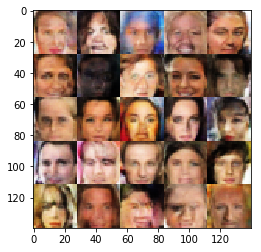

E 4/5 B 1725/3166... D: 0.5277... G: 1.8275
E 4/5 B 1745/3166... D: 1.1519... G: 0.5826
E 4/5 B 1765/3166... D: 0.5830... G: 1.2160
E 4/5 B 1785/3166... D: 1.4814... G: 0.4415
E 4/5 B 1805/3166... D: 0.5221... G: 1.5185
E 4/5 B 1825/3166... D: 0.9319... G: 0.7819
E 4/5 B 1845/3166... D: 0.5507... G: 1.5075
E 4/5 B 1865/3166... D: 0.7070... G: 2.4247
E 4/5 B 1885/3166... D: 1.8261... G: 0.4141
E 4/5 B 1905/3166... D: 1.7705... G: 0.3489


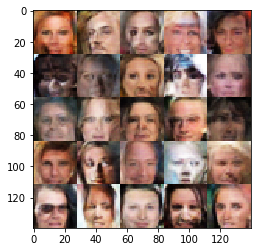

E 4/5 B 1925/3166... D: 0.8901... G: 0.8507
E 4/5 B 1945/3166... D: 0.7178... G: 1.1053
E 4/5 B 1965/3166... D: 1.1949... G: 0.5584
E 4/5 B 1985/3166... D: 0.5617... G: 1.3616
E 4/5 B 2005/3166... D: 0.5299... G: 1.3686
E 4/5 B 2025/3166... D: 0.5968... G: 2.3220
E 4/5 B 2045/3166... D: 2.0774... G: 0.2281
E 4/5 B 2065/3166... D: 1.0436... G: 3.0385
E 4/5 B 2085/3166... D: 0.7149... G: 1.0382
E 4/5 B 2105/3166... D: 1.0245... G: 0.8019


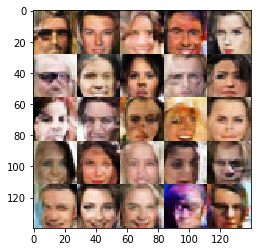

E 4/5 B 2125/3166... D: 0.9272... G: 0.8359
E 4/5 B 2145/3166... D: 0.7826... G: 1.1810
E 4/5 B 2165/3166... D: 0.4415... G: 1.8290
E 4/5 B 2185/3166... D: 0.8729... G: 0.9301
E 4/5 B 2205/3166... D: 0.5072... G: 1.4001
E 4/5 B 2225/3166... D: 0.4773... G: 2.2759
E 4/5 B 2245/3166... D: 0.6465... G: 1.2497
E 4/5 B 2265/3166... D: 1.2977... G: 3.3533
E 4/5 B 2285/3166... D: 0.7073... G: 1.3916
E 4/5 B 2305/3166... D: 1.2216... G: 0.6628


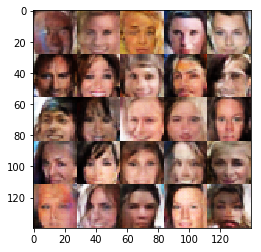

E 4/5 B 2325/3166... D: 0.9446... G: 0.8621
E 4/5 B 2345/3166... D: 0.9106... G: 0.8426
E 4/5 B 2365/3166... D: 0.6309... G: 1.3156
E 4/5 B 2385/3166... D: 0.5013... G: 1.8152
E 4/5 B 2405/3166... D: 0.8692... G: 2.5887
E 4/5 B 2425/3166... D: 1.4393... G: 0.4666
E 4/5 B 2445/3166... D: 0.9779... G: 0.8818
E 4/5 B 2465/3166... D: 0.6860... G: 1.1934
E 4/5 B 2485/3166... D: 0.4349... G: 1.8893
E 4/5 B 2505/3166... D: 0.9108... G: 0.7066


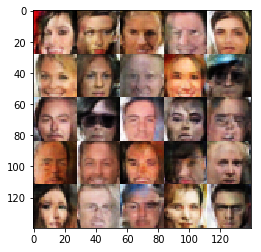

E 4/5 B 2525/3166... D: 1.0951... G: 0.6298
E 4/5 B 2545/3166... D: 0.4429... G: 1.9196
E 4/5 B 2565/3166... D: 1.1340... G: 0.7022
E 4/5 B 2585/3166... D: 0.8292... G: 1.1454
E 4/5 B 2605/3166... D: 0.7502... G: 1.1917
E 4/5 B 2625/3166... D: 0.8888... G: 0.8697
E 4/5 B 2645/3166... D: 0.8325... G: 0.9722
E 4/5 B 2665/3166... D: 0.5396... G: 1.3670
E 4/5 B 2685/3166... D: 1.0103... G: 0.8079
E 4/5 B 2705/3166... D: 1.3272... G: 0.5578


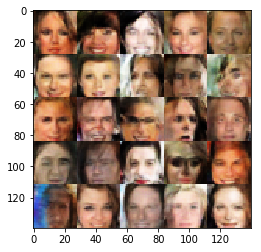

E 4/5 B 2725/3166... D: 0.8892... G: 0.9024
E 4/5 B 2745/3166... D: 1.2034... G: 0.6623
E 4/5 B 2765/3166... D: 0.8610... G: 1.1242
E 4/5 B 2785/3166... D: 0.6362... G: 1.3211
E 4/5 B 2805/3166... D: 0.8724... G: 0.8065
E 4/5 B 2825/3166... D: 0.9187... G: 0.7863
E 4/5 B 2845/3166... D: 0.5409... G: 1.1792
E 4/5 B 2865/3166... D: 0.3118... G: 3.0489
E 4/5 B 2885/3166... D: 1.3496... G: 0.4296
E 4/5 B 2905/3166... D: 1.1943... G: 0.6273


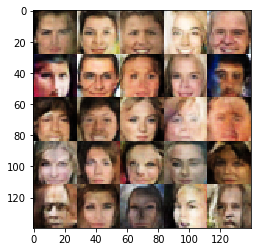

E 4/5 B 2925/3166... D: 0.5741... G: 1.3170
E 4/5 B 2945/3166... D: 0.3991... G: 2.5085
E 4/5 B 2965/3166... D: 1.1254... G: 0.8136
E 4/5 B 2985/3166... D: 0.7187... G: 0.9712
E 4/5 B 3005/3166... D: 0.5279... G: 1.5854
E 4/5 B 3025/3166... D: 0.4253... G: 2.6127
E 4/5 B 3045/3166... D: 0.3859... G: 1.6267
E 4/5 B 3065/3166... D: 1.2219... G: 2.9518
E 4/5 B 3085/3166... D: 1.4108... G: 2.4910
E 4/5 B 3105/3166... D: 0.7210... G: 1.3308


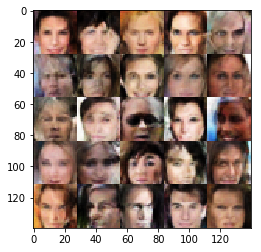

E 4/5 B 3125/3166... D: 0.5599... G: 1.2484
E 4/5 B 3145/3166... D: 0.6178... G: 1.8062
E 4/5 B 3165/3166... D: 0.9948... G: 0.8084
E 5/5 B   20/3166... D: 0.6953... G: 1.0879
E 5/5 B   40/3166... D: 0.4986... G: 1.4102
E 5/5 B   60/3166... D: 0.4349... G: 2.3377
E 5/5 B   80/3166... D: 0.6866... G: 1.1616
E 5/5 B  100/3166... D: 1.2396... G: 0.6912
E 5/5 B  120/3166... D: 0.9214... G: 0.9113
E 5/5 B  140/3166... D: 1.7037... G: 3.6326


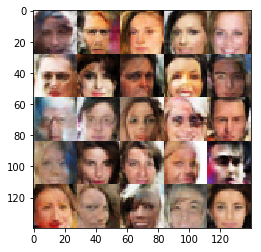

E 5/5 B  160/3166... D: 1.3191... G: 0.5152
E 5/5 B  180/3166... D: 0.6793... G: 1.1262
E 5/5 B  200/3166... D: 0.3160... G: 3.4495
E 5/5 B  220/3166... D: 0.6623... G: 1.6437
E 5/5 B  240/3166... D: 1.1489... G: 1.6884
E 5/5 B  260/3166... D: 0.6535... G: 2.6900
E 5/5 B  280/3166... D: 0.6661... G: 1.4313
E 5/5 B  300/3166... D: 0.9438... G: 0.8275
E 5/5 B  320/3166... D: 0.4951... G: 1.3654
E 5/5 B  340/3166... D: 0.6964... G: 1.0822


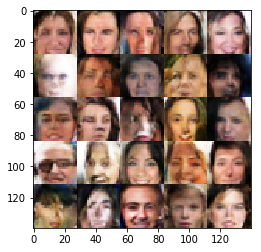

E 5/5 B  360/3166... D: 1.5379... G: 0.4034
E 5/5 B  380/3166... D: 0.4143... G: 2.1095
E 5/5 B  400/3166... D: 0.9539... G: 0.8328
E 5/5 B  420/3166... D: 0.5233... G: 1.7984
E 5/5 B  440/3166... D: 0.8714... G: 0.8415
E 5/5 B  460/3166... D: 0.6572... G: 1.1547
E 5/5 B  480/3166... D: 1.4271... G: 2.5814
E 5/5 B  500/3166... D: 0.9358... G: 0.8361
E 5/5 B  520/3166... D: 2.7259... G: 0.1477
E 5/5 B  540/3166... D: 0.8304... G: 0.9448


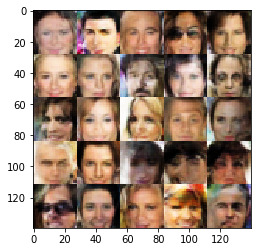

E 5/5 B  560/3166... D: 1.3963... G: 3.7802
E 5/5 B  580/3166... D: 1.5970... G: 0.3842
E 5/5 B  600/3166... D: 0.5684... G: 2.2262
E 5/5 B  620/3166... D: 0.7184... G: 1.1486
E 5/5 B  640/3166... D: 0.7720... G: 1.6194
E 5/5 B  660/3166... D: 0.6695... G: 1.3583
E 5/5 B  680/3166... D: 0.6008... G: 1.5004
E 5/5 B  700/3166... D: 0.8004... G: 1.0543
E 5/5 B  720/3166... D: 1.9797... G: 0.2351
E 5/5 B  740/3166... D: 1.0191... G: 0.7148


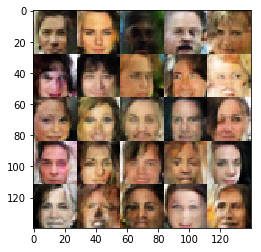

E 5/5 B  760/3166... D: 0.7815... G: 1.1754
E 5/5 B  780/3166... D: 0.5965... G: 1.3173
E 5/5 B  800/3166... D: 1.1259... G: 0.6398
E 5/5 B  820/3166... D: 0.6635... G: 1.3026
E 5/5 B  840/3166... D: 0.7884... G: 0.9659
E 5/5 B  860/3166... D: 0.4460... G: 2.0450
E 5/5 B  880/3166... D: 0.4945... G: 1.9681
E 5/5 B  900/3166... D: 0.6226... G: 3.2647
E 5/5 B  920/3166... D: 1.9036... G: 0.5219
E 5/5 B  940/3166... D: 1.6443... G: 0.4169


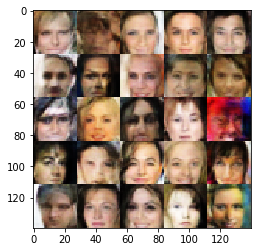

E 5/5 B  960/3166... D: 0.5885... G: 1.4431
E 5/5 B  980/3166... D: 0.7595... G: 1.0667
E 5/5 B 1000/3166... D: 0.8456... G: 0.8709
E 5/5 B 1020/3166... D: 0.9166... G: 1.1010
E 5/5 B 1040/3166... D: 0.9841... G: 1.9708
E 5/5 B 1060/3166... D: 0.7432... G: 1.1346
E 5/5 B 1080/3166... D: 0.7663... G: 1.1484
E 5/5 B 1100/3166... D: 0.4374... G: 2.3843
E 5/5 B 1120/3166... D: 1.3640... G: 0.6071
E 5/5 B 1140/3166... D: 0.7333... G: 2.3373


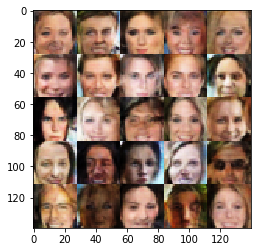

E 5/5 B 1160/3166... D: 0.7012... G: 1.1659
E 5/5 B 1180/3166... D: 1.0998... G: 0.6876
E 5/5 B 1200/3166... D: 0.7824... G: 1.0222
E 5/5 B 1220/3166... D: 1.0425... G: 0.7282
E 5/5 B 1240/3166... D: 0.5801... G: 1.2740
E 5/5 B 1260/3166... D: 2.3201... G: 3.4862
E 5/5 B 1280/3166... D: 0.8594... G: 1.1281
E 5/5 B 1300/3166... D: 0.9590... G: 0.7893
E 5/5 B 1320/3166... D: 0.7120... G: 1.3300
E 5/5 B 1340/3166... D: 1.3667... G: 0.5685


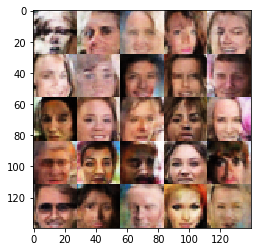

E 5/5 B 1360/3166... D: 0.6335... G: 1.2991
E 5/5 B 1380/3166... D: 1.3125... G: 0.5892
E 5/5 B 1400/3166... D: 1.0364... G: 0.7099
E 5/5 B 1420/3166... D: 0.4923... G: 1.7634
E 5/5 B 1440/3166... D: 0.6272... G: 1.3810
E 5/5 B 1460/3166... D: 0.8311... G: 0.9137
E 5/5 B 1480/3166... D: 0.3960... G: 1.8380
E 5/5 B 1500/3166... D: 0.4800... G: 1.5372
E 5/5 B 1520/3166... D: 0.4049... G: 2.7606
E 5/5 B 1540/3166... D: 0.8653... G: 0.9225


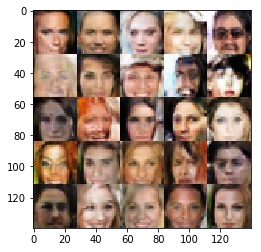

E 5/5 B 1560/3166... D: 0.7449... G: 0.9899
E 5/5 B 1580/3166... D: 0.2587... G: 2.4745
E 5/5 B 1600/3166... D: 1.1671... G: 0.6615
E 5/5 B 1620/3166... D: 1.2359... G: 1.0131
E 5/5 B 1640/3166... D: 0.6449... G: 1.4649
E 5/5 B 1660/3166... D: 0.4098... G: 1.9732
E 5/5 B 1680/3166... D: 1.9935... G: 0.2306
E 5/5 B 1700/3166... D: 0.8072... G: 0.9213
E 5/5 B 1720/3166... D: 0.8736... G: 0.9599
E 5/5 B 1740/3166... D: 0.8778... G: 0.9023


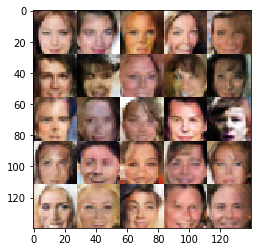

E 5/5 B 1760/3166... D: 1.7126... G: 1.0343
E 5/5 B 1780/3166... D: 1.0250... G: 0.8474
E 5/5 B 1800/3166... D: 1.6448... G: 0.3913
E 5/5 B 1820/3166... D: 0.6235... G: 1.4486
E 5/5 B 1840/3166... D: 0.7454... G: 1.0226
E 5/5 B 1860/3166... D: 0.6109... G: 1.3818
E 5/5 B 1880/3166... D: 0.6477... G: 1.3259
E 5/5 B 1900/3166... D: 0.5791... G: 1.3124
E 5/5 B 1920/3166... D: 0.4767... G: 1.7130
E 5/5 B 1940/3166... D: 2.3279... G: 4.6266


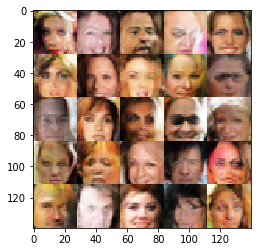

E 5/5 B 1960/3166... D: 1.0828... G: 0.8225
E 5/5 B 1980/3166... D: 0.8350... G: 1.0548
E 5/5 B 2000/3166... D: 0.9700... G: 0.7596
E 5/5 B 2020/3166... D: 0.6204... G: 1.1210
E 5/5 B 2040/3166... D: 0.8300... G: 3.8954
E 5/5 B 2060/3166... D: 1.1663... G: 0.6752
E 5/5 B 2080/3166... D: 0.3179... G: 2.3448
E 5/5 B 2100/3166... D: 0.5973... G: 1.3068
E 5/5 B 2120/3166... D: 0.7463... G: 0.9887
E 5/5 B 2140/3166... D: 1.1462... G: 3.1876


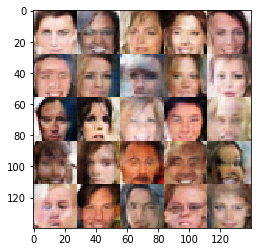

E 5/5 B 2160/3166... D: 0.8557... G: 0.9030
E 5/5 B 2180/3166... D: 0.9152... G: 0.8544
E 5/5 B 2200/3166... D: 1.0265... G: 3.1131
E 5/5 B 2220/3166... D: 0.6345... G: 2.1664
E 5/5 B 2240/3166... D: 0.8524... G: 0.9160
E 5/5 B 2260/3166... D: 1.0091... G: 0.6814
E 5/5 B 2280/3166... D: 0.4550... G: 1.9775
E 5/5 B 2300/3166... D: 0.8340... G: 1.0736
E 5/5 B 2320/3166... D: 0.7281... G: 1.1279
E 5/5 B 2340/3166... D: 0.6790... G: 1.3223


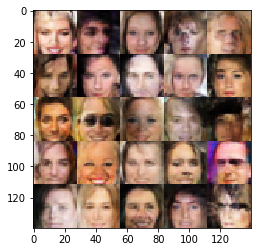

E 5/5 B 2360/3166... D: 0.7253... G: 1.3258
E 5/5 B 2380/3166... D: 2.2795... G: 4.5613
E 5/5 B 2400/3166... D: 1.4263... G: 0.5507
E 5/5 B 2420/3166... D: 0.5158... G: 1.6673
E 5/5 B 2440/3166... D: 1.5196... G: 0.5323
E 5/5 B 2460/3166... D: 1.0387... G: 0.7299
E 5/5 B 2480/3166... D: 0.7961... G: 1.4273
E 5/5 B 2500/3166... D: 0.6878... G: 1.2877
E 5/5 B 2520/3166... D: 0.5442... G: 1.4670
E 5/5 B 2540/3166... D: 0.7284... G: 1.1856


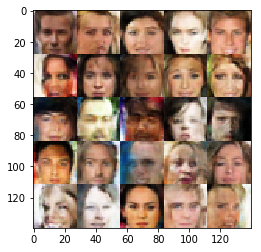

E 5/5 B 2560/3166... D: 0.4754... G: 1.7273
E 5/5 B 2580/3166... D: 0.6018... G: 2.4177
E 5/5 B 2600/3166... D: 0.4335... G: 1.7094
E 5/5 B 2620/3166... D: 0.4210... G: 1.8578
E 5/5 B 2640/3166... D: 0.5863... G: 1.4575
E 5/5 B 2660/3166... D: 0.4924... G: 1.6059
E 5/5 B 2680/3166... D: 0.7484... G: 1.1789
E 5/5 B 2700/3166... D: 1.4255... G: 0.4414
E 5/5 B 2720/3166... D: 0.8848... G: 2.1020
E 5/5 B 2740/3166... D: 0.7791... G: 1.2804


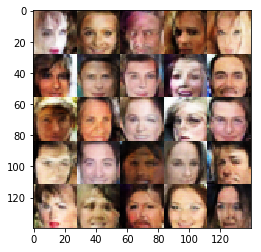

E 5/5 B 2760/3166... D: 1.0068... G: 0.6970
E 5/5 B 2780/3166... D: 0.6547... G: 1.0289
E 5/5 B 2800/3166... D: 1.1420... G: 0.6814
E 5/5 B 2820/3166... D: 0.6567... G: 1.4728
E 5/5 B 2840/3166... D: 0.7396... G: 2.0727
E 5/5 B 2860/3166... D: 0.7071... G: 1.6625
E 5/5 B 2880/3166... D: 0.6596... G: 1.4666
E 5/5 B 2900/3166... D: 0.5388... G: 1.7362
E 5/5 B 2920/3166... D: 0.8747... G: 2.2395
E 5/5 B 2940/3166... D: 0.8041... G: 0.9450


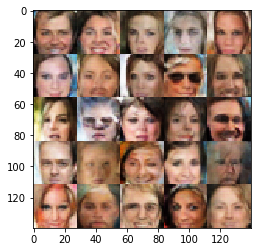

E 5/5 B 2960/3166... D: 0.5282... G: 2.6543
E 5/5 B 2980/3166... D: 1.0743... G: 0.7044
E 5/5 B 3000/3166... D: 0.5736... G: 1.5423
E 5/5 B 3020/3166... D: 0.3889... G: 1.9293
E 5/5 B 3040/3166... D: 0.5044... G: 1.8943
E 5/5 B 3060/3166... D: 0.8374... G: 1.3992
E 5/5 B 3080/3166... D: 0.4265... G: 1.9145
E 5/5 B 3100/3166... D: 0.7267... G: 1.2578
E 5/5 B 3120/3166... D: 1.1179... G: 0.7346
E 5/5 B 3140/3166... D: 0.8568... G: 0.9290


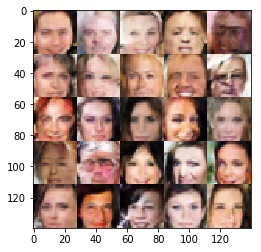

E 5/5 B 3160/3166... D: 0.9967... G: 0.7942


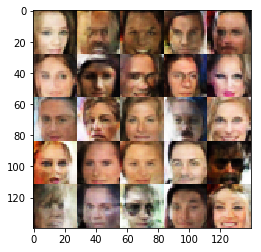

In [11]:
batch_size = 64
z_dim = 200
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。